In [1]:
import os
import sys
import datetime 
import numpy as np
import math
sys.path.append("..")
# from tqdm.rich import tqdm, trange
from tqdm import tqdm, trange
from copy import deepcopy
import h5py
import pandas as pd 

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchmetrics.regression import MeanAbsolutePercentageError

import seaborn as sns
import matplotlib.pylab as plt

from data import get_database_path, get_h5_files, read_h5_file, select_events



In [2]:
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Set default tensor type
if sys.platform == "darwin":
    # Mac OS
    default_precision = torch.float32
else:
    # Linux or Windows
    default_precision = torch.float64
torch.set_default_dtype(default_precision)

# Set device
#device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
print(f"Using {device} device")

Using cuda device


# Load dataset

In [3]:
database_path = get_database_path()
bkg_files, sig_files = get_h5_files()


# SM processes
bkg = read_h5_file(database_path, bkg_files[0]['file'])
bkg_pairs, bkg_emds = read_h5_file(database_path, "bkg_emds.h5", datatype='EMD')

In [4]:
from data import PairedEventsDataset, RealTimeEMDDataset

In [ ]:
print(len(bkg), len(bkg_pairs), len(bkg_emds))
train_val_split = 0.8
train_size = int(len(bkg_pairs) * train_val_split)
print(train_size)

In [ ]:
train_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[:train_size], bkg_emds[:train_size])
val_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[train_size:], bkg_emds[train_size:])

In [5]:
selected_train = 200000
selected_val = 100000
train_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[:selected_train], bkg_emds[:selected_train])
val_bkg_dataset = PairedEventsDataset(bkg, bkg_pairs[-selected_val:], bkg_emds[-selected_val:])
print(len(train_bkg_dataset), len(val_bkg_dataset))

200000 100000


In [6]:
train_bkg_dataloader = DataLoader(train_bkg_dataset, batch_size=256, shuffle=True)
val_bkg_dataloader = DataLoader(val_bkg_dataset, batch_size=256, pin_memory=True)

# Model

In [7]:
from model import ParticleEventTransformer, particleTransformer

# Loss & Metric

In [8]:
from torchmetrics.regression import MeanAbsolutePercentageError
from metrics import MetricUpdater, MAPE_dispersion, embed_ratio

MAPE = MeanAbsolutePercentageError().to(device)
MAPE_updater = MetricUpdater(MAPE)
MAPE_dispersion_updater = MetricUpdater(MAPE_dispersion)
embed_ratio_updater = MetricUpdater(embed_ratio)


In [9]:
metric_dict = {"MAPE": MAPE_updater, "MAPE on index of dispersion": MAPE_dispersion_updater, "Embed Ratio": embed_ratio_updater}

# Train Pipeline

In [10]:
from train import train_model

# Train!

In [11]:
feature_size = 3  # pT, eta, phi
embed_size = 16  # Dimension of embedding space
num_heads = 4    # Number of attention heads
hidden_dim = 256 # Dimension of the feedforward network model in nn.TransformerEncoder
output_dim = 5  # Final dimension of the output embedding
num_layers = 4   # Number of nn.TransformerEncoderLayer

model = ParticleEventTransformer(feature_size, embed_size, num_heads, hidden_dim, output_dim, num_layers)
# model = particleTransformer(feature_size, d_model=embed_size, nhead=num_heads, num_encoder_layers=num_layers, embed_dim=output_dim, max_seq_length=19, pos_dropout=0.1, layer_widths=[200,50,10])

model.to(device)
def loss_function(embed_dist, emd):
    # return MAPE(embed_dist, emd)
    return MAPE(embed_dist, emd) + torch.var(embed_dist / emd)
from metrics import Euclidean_distance, hyperbolic_distance
dist_fn = Euclidean_distance
# dist_fn = hyperbolic_distance
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

/home/desmondhe/anaconda3/envs/ad/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
dfhistory = train_model(model, optimizer, 
                        loss_function, dist_fn, metric_dict, 
                        train_dataloader=train_bkg_dataloader, val_dataloader=val_bkg_dataloader,
                        monitor="val_MAPE", mode="min",
                        epochs=50)

In [12]:
opt_train_model = torch.compile(train_model)

In [13]:
dfhistory = opt_train_model(model, optimizer, 
                        loss_function, dist_fn, metric_dict, 
                        train_dataloader=train_bkg_dataloader, val_dataloader=val_bkg_dataloader,
                        monitor="val_MAPE", mode="min",
                        epochs=50)


================================================================================2024-05-01 22:27:30
Epoch 1 / 50

100%|██████████| 391/391 [00:14<00:00, 26.56it/s, val_Embed Ratio=165, val_MAPE=164, val_MAPE on index of dispersion=51.8, val_loss=0.938]  
<<<<<< reach best val_MAPE : 164.41279248946674 >>>>>>

================================================================================2024-05-01 22:29:02
Epoch 2 / 50

100%|██████████| 391/391 [00:04<00:00, 87.97it/s, val_Embed Ratio=91.9, val_MAPE=90.9, val_MAPE on index of dispersion=53.5, val_loss=0.935]
<<<<<< reach best val_MAPE : 90.90466494198473 >>>>>>

================================================================================2024-05-01 22:29:28
Epoch 3 / 50

100%|██████████| 391/391 [00:04<00:00, 91.73it/s, val_Embed Ratio=43.3, val_MAPE=42.3, val_MAPE on index of dispersion=75.7, val_loss=0.923]
<<<<<< reach best val_MAPE : 42.342348460206566 >>>>>>

===================================================================

In [14]:
from visualize import plot_train_history

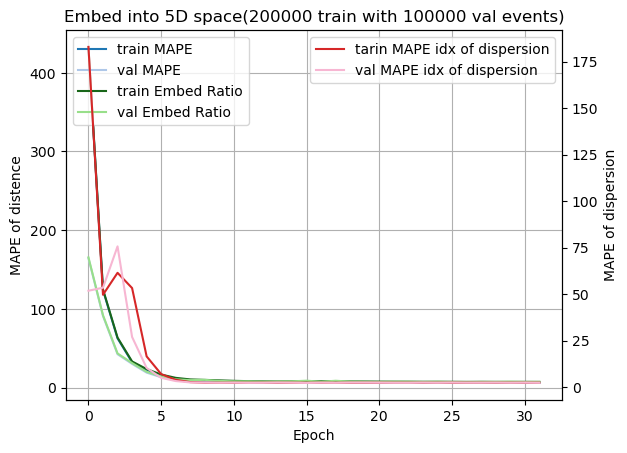

In [15]:
plot_train_history(dfhistory, "Embed into {}D space({} train with {} val events)".format(output_dim, len(train_bkg_dataset), len(val_bkg_dataset)))

In [16]:
@torch.no_grad()
def inference(model, dataloader, embed_dim=2):
    model.eval()
    embed = np.zeros((len(dataloader.dataset), embed_dim))
    for i, event in enumerate(tqdm(dataloader)):
        event = event.to(device)
        output = model(event)
        embed[i*len(event):(i+1)*len(event)] = output.cpu().numpy()
    return embed

In [17]:
from data import EventDataset

In [18]:
infer_test_num = 1000000
bkg_infer_test = bkg[:infer_test_num]
infer_dataset = EventDataset(bkg_infer_test)
infer_dataloader = DataLoader(infer_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

In [19]:
embed_points = inference(model, infer_dataloader, embed_dim=output_dim)

100%|██████████| 3907/3907 [00:20<00:00, 187.14it/s]


In [20]:
print(embed_points.shape)

(1000000, 5)


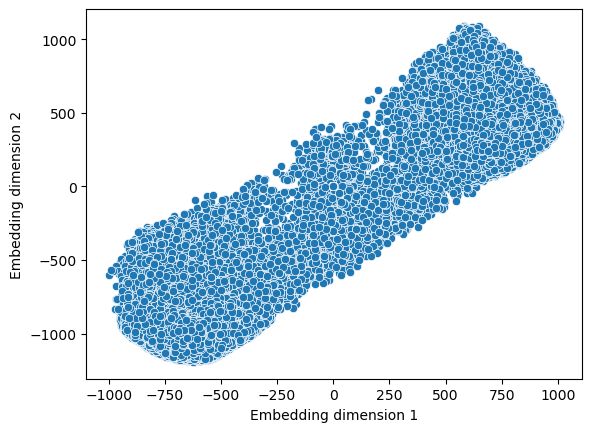

In [21]:
sns.scatterplot(x=embed_points[:,0], y=embed_points[:,1])
plt.xlabel("Embedding dimension 1")
plt.ylabel("Embedding dimension 2")
plt.show()

In [22]:
only_electron_index = select_events(bkg_infer_test, [1,0,0])
events_with_only_electron = bkg_infer_test[only_electron_index]
print(events_with_only_electron.shape)
events_with_only_electron_embed = embed_points[only_electron_index]

(205660, 19, 4)


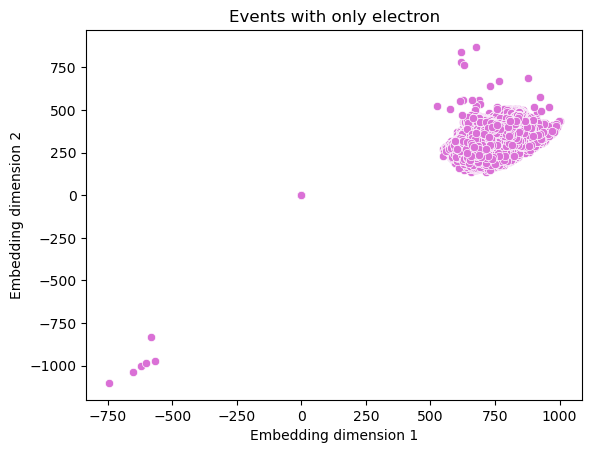

In [23]:
sns.scatterplot(x=events_with_only_electron_embed[:,0], color='#DA70D6', y=events_with_only_electron_embed[:,1])
plt.xlabel("Embedding dimension 1")
plt.ylabel("Embedding dimension 2")
plt.title("Events with only electron")
plt.show()

In [24]:
only_muon_index = select_events(bkg_infer_test, [0,1,0])
events_with_only_muon = bkg_infer_test[only_muon_index]
print(events_with_only_muon.shape)
events_with_only_muon_embed = embed_points[only_muon_index]

(171112, 19, 4)


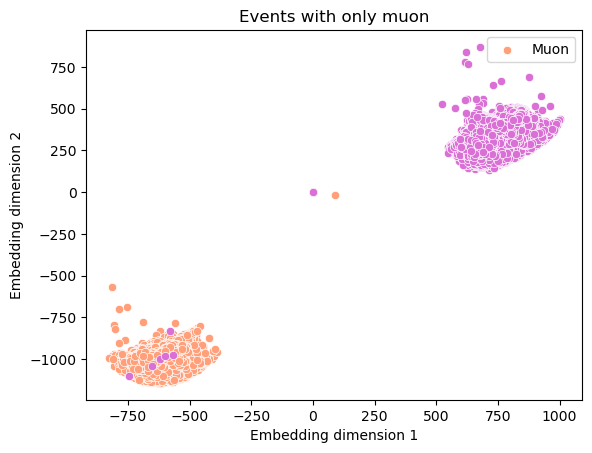

In [41]:
sns.scatterplot(x=events_with_only_muon_embed[:,0], y=events_with_only_muon_embed[:,1], color='#FFA07A', label="Muon")
sns.scatterplot(x=events_with_only_electron_embed[:,0], color='#DA70D6', y=events_with_only_electron_embed[:,1])
plt.xlabel("Embedding dimension 1")
plt.ylabel("Embedding dimension 2")
plt.title("Events with only muon")
plt.show()

In [26]:
eletron_and_muon_without_jets_index = select_events(bkg_infer_test, [1,1,0])
events_with_eletron_and_muon = bkg_infer_test[eletron_and_muon_without_jets_index]
print(events_with_eletron_and_muon.shape)
events_with_eletron_and_muon_embed = embed_points[eletron_and_muon_without_jets_index]

(399, 19, 4)


In [36]:
eletron_with_jets_index = select_events(bkg_infer_test, [1,0,1])
events_with_eletron_and_jets = bkg_infer_test[eletron_with_jets_index]
print(events_with_eletron_and_jets.shape)
events_with_eletron_and_jets_embed = embed_points[eletron_with_jets_index]

muon_with_jets_index = select_events(bkg_infer_test, [0,1,1])
events_with_muon_and_jets = bkg_infer_test[muon_with_jets_index]
print(events_with_muon_and_jets.shape)
events_with_muon_and_jets_embed = embed_points[muon_with_jets_index]

(316404, 19, 4)
(283946, 19, 4)


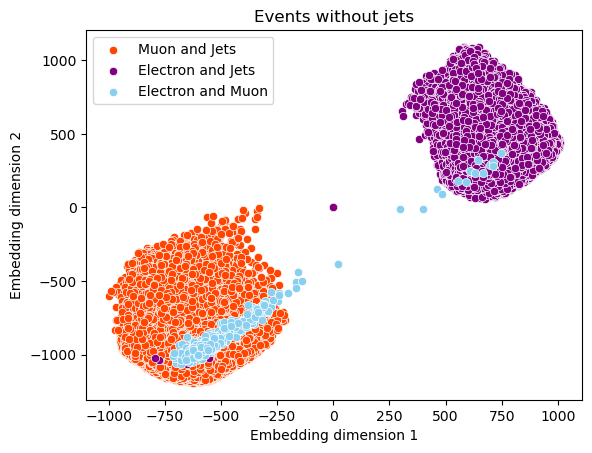

In [40]:
# sns.scatterplot(x=events_with_only_muon_embed[:,0], y=events_with_only_muon_embed[:,1], color='#FFA07A', label="Muon")
sns.scatterplot(x=events_with_muon_and_jets_embed[:,0], y=events_with_muon_and_jets_embed[:,1], color='#FF4500', label="Muon and Jets")
# sns.scatterplot(x=events_with_only_electron_embed[:,0], y=events_with_only_electron_embed[:,1], color='#DA70D6', label="Electron")
sns.scatterplot(x=events_with_eletron_and_jets_embed[:,0], y=events_with_eletron_and_jets_embed[:,1], color='#800080', label="Electron and Jets")
sns.scatterplot(x=events_with_eletron_and_muon_embed[:,0], y=events_with_eletron_and_muon_embed[:,1], color='#89CFF0', label="Electron and Muon")
plt.legend()
plt.xlabel("Embedding dimension 1")
plt.ylabel("Embedding dimension 2")
plt.title("Events without jets")
plt.show()

In [28]:
e_mu_jets_index = (bkg_infer_test[:,1,3] == 2) & (bkg_infer_test[:,5,3] == 3) & (bkg_infer_test[:,9,3] == 4)
events_with_e_mu_jets = bkg_infer_test[e_mu_jets_index]
print(events_with_e_mu_jets.shape)
events_with_e_mu_jets_embed = embed_points[e_mu_jets_index]

(22479, 19, 4)


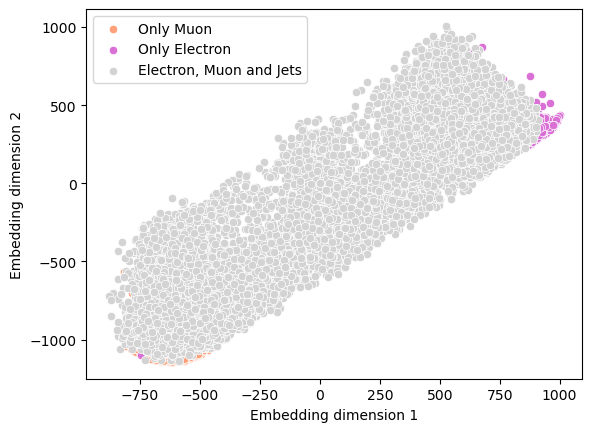

In [29]:
sns.scatterplot(x=events_with_only_muon_embed[:,0], y=events_with_only_muon_embed[:,1], color='#FFA07A', label="Only Muon")
sns.scatterplot(x=events_with_only_electron_embed[:,0], y=events_with_only_electron_embed[:,1], color='#DA70D6', label="Only Electron")
sns.scatterplot(x=events_with_e_mu_jets_embed[:,0], y=events_with_e_mu_jets_embed[:,1], color='#D3D3D3', label="Electron, Muon and Jets")
plt.legend()
plt.xlabel("Embedding dimension 1")
plt.ylabel("Embedding dimension 2")
plt.show()

In [30]:
neutral_boson = read_h5_file(database_path, sig_files[0]['file'])
# A neutral scalar boson (A) with mass 50 GeV, decaying to two off-shell Z bosons, each forced to decay to two leptons: A → 4l

neutral_boson_dataset = EventDataset(neutral_boson)
neutral_boson_dataloader = DataLoader(neutral_boson_dataset, batch_size=256, num_workers=16, prefetch_factor=5)

In [31]:
neutral_boson_embed_points = inference(model, neutral_boson_dataloader, embed_dim=output_dim)

100%|██████████| 219/219 [00:01<00:00, 129.39it/s]


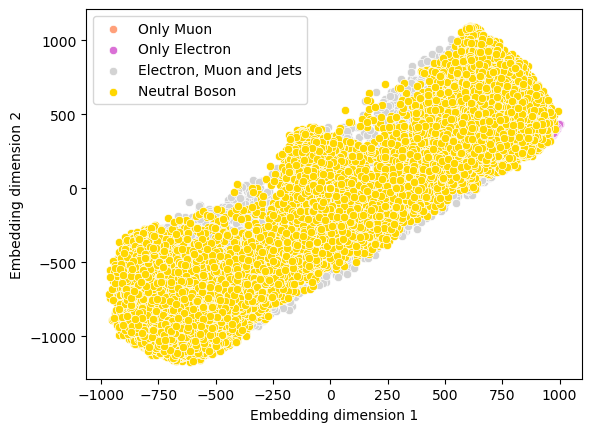

In [32]:
sns.scatterplot(x=events_with_only_muon_embed[:,0], y=events_with_only_muon_embed[:,1], color='#FFA07A', label="Only Muon")
sns.scatterplot(x=events_with_only_electron_embed[:,0], y=events_with_only_electron_embed[:,1], color='#DA70D6', label="Only Electron")
sns.scatterplot(x=events_with_e_mu_jets_embed[:,0], y=events_with_e_mu_jets_embed[:,1], color='#D3D3D3', label="Electron, Muon and Jets")
sns.scatterplot(x=neutral_boson_embed_points[:,0], y=neutral_boson_embed_points[:,1], color='#FFD700', label="Neutral Boson")

plt.legend()
plt.xlabel("Embedding dimension 1")
plt.ylabel("Embedding dimension 2")
plt.show()

In [ ]:
from emd import emd_pot
from visualize import plot_optimal_transport

In [ ]:
source_event_index = np.random.randint(len(bkg_infer_test))
target_event_index = np.random.randint(len(bkg_infer_test))

emd, flowmatrix = emd_pot(bkg_infer_test[source_event_index], bkg_infer_test[target_event_index], return_flow=True)
plot_optimal_transport(bkg_infer_test[source_event_index], bkg_infer_test[target_event_index], flowmatrix, emd)
sns.scatterplot(x=[embed_points[source_event_index,0]], y=[embed_points[source_event_index,1]], color='red', label="Source event")
sns.scatterplot(x=[embed_points[target_event_index,0]], y=[embed_points[target_event_index,1]], color='blue', label="Target event")
plt.xlim(np.min(embed_points[:,0]), np.max(embed_points[:,0]))
plt.ylim(np.min(embed_points[:,1]), np.max(embed_points[:,1]))
plt.legend()
plt.xlabel("Embedding dimension 1")
plt.ylabel("Embedding dimension 2")
plt.show()

In [ ]:
sns.scatterplot(x=[embed_points[source_event_index,0]], y=[embed_points[source_event_index,1]], color='red', label="Source event")
sns.scatterplot(x=[embed_points[target_event_index,0]], y=[embed_points[target_event_index,1]], color='blue', label="Target event")
plt.xlim(np.min(embed_points[:,0]), np.max(embed_points[:,0]))
plt.ylim(np.min(embed_points[:,1]), np.max(embed_points[:,1]))
plt.legend()
plt.xlabel("Embedding dimension 1")
plt.ylabel("Embedding dimension 2")
plt.show()

In [ ]:
%load_ext autoreload
%autoreload 1
%aimport visualize